## Lab 4 Convolution

### Predicting Digits

Notes on M.L. Libraries

Potential libraries to use:

Theano

Tensorflow, Google

    could remake this in notebook for assignment:
    
    https://github.com/tensorflow/tensorflow/blob/r1.4/tensorflow/examples/tutorials/mnist/mnist_deep.py
    
Torch/Pytorch, Facebook

CNTK(gluon)

Keras

    pip install --update keras
    
(more options in c++/cuda)

For this project I will be using Keras for data training. For a decent introduction to keras see: https://yashk2810.github.io/Applying-Convolutional-Neural-Network-on-the-MNIST-dataset/

In [18]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.models import Model # basic class for specifying and training a neural network
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils # utilities for one-hot encoding of ground truth values
import numpy as np

(X_train, y_train), (X_test, y_test) = mnist.load_data() 
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
num_train, height, width, depth = X_train.shape # there are 50000 training examples
num_test = X_test.shape[0] # there are 10000 test examples
num_classes = np.unique(y_train).shape[0] # there are 10 image classes

X_train = X_train.astype('float32') 
X_test = X_test.astype('float32')
X_train/= 255 # Normalise data to [0, 1] range
X_test/= 255 # Normalise data to [0, 1] range

Y_train = np_utils.to_categorical(y_train, num_classes) # One-hot encode the labels
Y_test = np_utils.to_categorical(y_test, num_classes) # One-hot encode the labels

inp = Input(shape=(height, width, depth)) # depth goes last in TensorFlow back-end

print(X_test.shape)
print(X_train.shape)

(10000, 28, 28, 1)
(60000, 28, 28, 1)


In [27]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

def print_data(testx, testy, m):#m for model
    score = m.evaluate(testx, testy, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])#print accuracy    
    predictions = model.predict_classes(testx)
    Y_t = np.argmax(testy, axis=1)
    print(precision_recall_fscore_support(Y_t, predictions))
    print("Classification")
    print(classification_report(Y_t, predictions))
    print("Confusion Matrix")
    print(confusion_matrix(Y_t, predictions))

In [28]:
batch_size = 28 # in each iteration, we consider 28 training examples at once
num_epochs = 15 # we iterate 200 times over the entire training set
k_size = 3 # we will use 3x3 kernels throughout
pool_size = 2 # we will use 2x2 pooling throughout
conv_depth_1 = 32 # we will initially have 32 kernels per conv. layer...
conv_depth_2 = 64 # ...switching to 64 after the first pooling layer
drop_prob_1 = 0.25 # dropout after pooling with probability 0.25
drop_prob_2 = 0.5 # dropout in the FC layer with probability 0.5
hidden_size = 512 # the FC layer will have 512 neurons
pad='same'

m1 = Sequential()
m1.add(Conv2D(conv_depth_1, (k_size, k_size), activation='relu', input_shape=(28,28,1)))
BatchNormalization(axis=-1)
m1.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

m1.add(Flatten())
m1.add(Dense(conv_depth_2, activation='relu'))#neural network layer
BatchNormalization()
m1.add(Dense(num_classes, activation='softmax'))
m1.summary()
m1.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
m1.fit(X_train, Y_train, batch_size=batch_size,
          epochs=num_epochs, verbose=1,
          validation_data=(X_test, Y_test))#removed callbacks=[history]

print_data(X_test, Y_test, m1)
#unused code from an example i found
## Conv [32] -> Conv [32] -> Pool (with dropout on the pooling layer)
#conv_1 = Convolution2D(conv_depth_1, (kernel_size, kernel_size), padding='same', activation='relu')(inp)
#conv_2 = Convolution2D(conv_depth_1, (kernel_size, kernel_size), padding='same', activation='relu')(conv_1)
#pool_1 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_2)
#drop_1 = Dropout(drop_prob_1)(pool_1)
## Conv [64] -> Conv [64] -> Pool (with dropout on the pooling layer)
#conv_3 = Convolution2D(conv_depth_2, (kernel_size, kernel_size), padding='same', activation='relu')(drop_1)
#conv_4 = Convolution2D(conv_depth_2, (kernel_size, kernel_size), padding='same', activation='relu')(conv_3)
#pool_2 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_4)
#drop_2 = Dropout(drop_prob_1)(pool_2)
## Now flatten to 1D, apply FC -> ReLU (with dropout) -> softmax
#flat = Flatten()(drop_2)
#hidden = Dense(hidden_size, activation='relu')(flat)
#drop_3 = Dropout(drop_prob_2)(hidden)
#out = Dense(num_classes, activation='softmax')(drop_3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                346176    
_________________________________________________________________
dense_12 (Dense)             (None, 10)                650       
Total params: 347,146
Trainable params: 347,146
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 39s 656us/step - loss: 0.159

### Results of Run

For this model I used once convolutional layer with 32 kernels, and one fully connected neural network layer that fed into a softmax output layer. The model came up with a 98.48% accuracy. The model was most often wrong when it came to the digit 9 being predicted as a 4, which to be honest seems like an almost human mistake.

(2,)
[ array([[[[ 0.08820431, -0.44641867, -0.88097876, -0.07507395, -0.40566126,
           0.06497961,  0.1707484 , -0.01209065, -0.27897948, -0.14978291,
          -0.30384451,  0.36983857,  0.08988312,  0.18144797,  0.02842912,
           0.30834857, -0.38621953, -0.66700631, -0.26434869, -0.91094416,
          -0.3520191 , -0.5449453 ,  0.19656755,  0.18398382,  0.27702123,
          -0.59177518, -0.45021373,  0.33859068, -0.17936404,  0.18795776,
           0.37416011, -0.99000853]],

        [[ 0.00494679, -0.34724867, -0.51450425, -0.05088293, -0.31316292,
           0.31603613,  0.15382288,  0.65434849,  0.18235071,  0.16415694,
          -0.39756277, -0.10513358, -0.4093996 ,  0.31778014,  0.26132372,
           0.24170583,  0.17828439, -0.21541643, -0.57579166, -0.02866375,
           0.39694309,  0.25372797, -0.20952141,  0.18458132,  0.42046866,
          -0.0938383 ,  0.14909534,  0.04610151,  0.00885721,  0.15340136,
          -0.17662215, -0.42633432]],

        [[ 0.31

TypeError: Image data cannot be converted to float

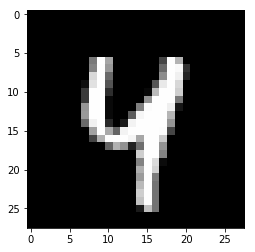

In [82]:
#attempt at printing convolved image
import matplotlib.pyplot as plt
plt.imshow(np.squeeze(X_test[42]), cmap='gray')

#con = Conv2D(conv_depth_1, (k_size, k_size), activation='relu', input_shape=(28,28,1))
tmp = m1.layers[0].get_weights()
np_tmp = np.asarray(tmp)
np_tmp = np.squeeze(np_tmp)
print(np_tmp.shape)
print(np_tmp)
#tmp = np.expand_dims(tmp, axis=0)
#t2 = np.array(tmp, dtype=float)
plt.imshow(np_tmp, cmap='gray')

In [35]:
#code edited from: https://github.com/yashk2810/Visualization-of-Convolutional-Layers/blob/master/Visualizing%20Filters%20Python3%20Theano%20Backend.ipynb
def visualize_layer(layer, modl, example_image):
    inputs = [K.learning_phase()] + modl.inputs
    _convout1_f = K.function(inputs, [layer.output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    convolutions = convout1_f(example_image)
    convolutions = np.squeeze(convolutions)
    print ('Shape of conv:', convolutions.shape)
    
    n = convolutions.shape[0]
    n = int(np.ceil(np.sqrt(n)))
    
    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(12,8))
    for i in range(len(convolutions)):
        ax = fig.add_subplot(n,n,i+1)
        ax.imshow(convolutions[i], cmap='gray')

In [38]:
X_example = X_test[42]
X_example = np.expand_dims(X_example, axis=0)
visualize_layer(m1.layers[0], m1, )

TypeError: visualize_layer() takes 1 positional argument but 2 were given

In [25]:
#function for creating simple model
#def train_cnn(xt, yt, xtrain, ytrain, c_depth, kern_sizes, padding, layers):# padding='valid' | 'same' and activation='relu'
#    model = Sequential()
#    input_shape = Input(shape=(height, width, depth))
#    model.add(Conv2D(32, (kern_sizes[0], kern_sizes[0]), padding, activation='relu',
#                 input_shape=input_shape))

batch_size = 28 # in each iteration, we consider 28 training examples at once
num_epochs = 15 # we iterate 200 times over the entire training set
k_size = 3 # we will use 3x3 kernels throughout
pool_size = 2 # we will use 2x2 pooling throughout
conv_depth_1 = 32 # we will initially have 32 kernels per conv. layer...
conv_depth_2 = 64 # ...switching to 64 after the first pooling layer
drop_prob_1 = 0.25 # dropout after pooling with probability 0.25
drop_prob_2 = 0.5 # dropout in the FC layer with probability 0.5
hidden_size = 512 # the FC layer will have 512 neurons
pad='same'

model = Sequential()
model.add(Conv2D(conv_depth_1, (k_size, k_size), activation='relu', input_shape=(28,28,1)))#convolution one
BatchNormalization(axis=-1)
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Conv2D(conv_depth_2, (k_size, k_size), activation='relu', input_shape=(28,28,1)))#convolution 2
BatchNormalization(axis=-1)

model.add(Flatten())
model.add(Dense(hidden_size, activation='relu'))#neural network layer
BatchNormalization()
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=batch_size,
          epochs=num_epochs, verbose=1,
          validation_data=(X_test, Y_test))#removed callbacks=[history]
print_data(X_test, Y_test, model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_4 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               3965440   
_________________________________________________________________
dense_8 (Dense)              (None, 10)                5130      
Total params: 3,989,386
Trainable params: 3,989,386
Non-trainable params: 0
_________________________________________________________________
